# Prompt Engineering

## Loading a Text Generation Model
Load the model using the `Transformers` library

In [ ]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [ ]:
from tqdm import tqdm

# Load the model and Tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map = "mps",
    torch_dtype = torch.float16,
    trust_remote_code = True,
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    return_full_text = False,
    max_new_tokens = 500,
    do_sample = True
)

                                          

In [ ]:
# Prompt
messages = [
    {
        "role" : "user",
        "content" : "Create a funny joke on Mars"
    }
]

# Generate the output
output = pipe(messages)
print(output[0]["generated_text"])

Under the hood, transformers.pipeline first converts our messages into a specific prompt template. We can explore this process by accessing the underlying tokenizer.

In [ ]:
# Apply prompt template
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize = False)
print(prompt)

# Setting parameter `tokenize = True`
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize = True)
print("\n",prompt)

`transformers.pipeline` handles chat template processing for us.

## Controlling Model Output

When we loaded our model, we purposefully set do_sample=False to make sure the output is somewhat consistent. This means that no sampling will be done and only the most probable next token is selected. However, to use the `temperature` and `top_p` parameters, we will set do_sample=True in order to make use of them.




### Temperature
The temperature controls the randomness or creativity of the text generated. It defines how likely it is to choose tokens that are less probable. The underlying idea is that a temperature of 0 generates the same response every time because it always chooses the most likely word. A higher value allows less probable words to be generated.

A higher temperature increases the likelihood that less probable tokens are
generated and vice versa. As a result, a higher temperature (e.g., 0.8) generally results in a more diverse output while a lower temperature (e.g., 0.2) creates a more deterministic output.

In [ ]:
# Using a high Temperature
output = pipe(messages, do_sample = True, temperature = 1)
print(output[0]["generated_text"])

### `top_p`
`top_p`, also known as nucleus sampling, is a sampling technique that controls which subset of tokens (the nucleus) the LLM can consider. It will consider tokens until it reaches their cumulative probability. If we set top_p to 0.1, it will consider tokens until it reaches that value. If we set top_p to 1, it will consider all tokens.

A higher top_p increases the number of tokens that can be selected to
generate and vice versa.

In [ ]:
# Using a high top_p
output = pipe(messages, do_sample = True, top_p = 1)
print(output[0]["generated_text"])

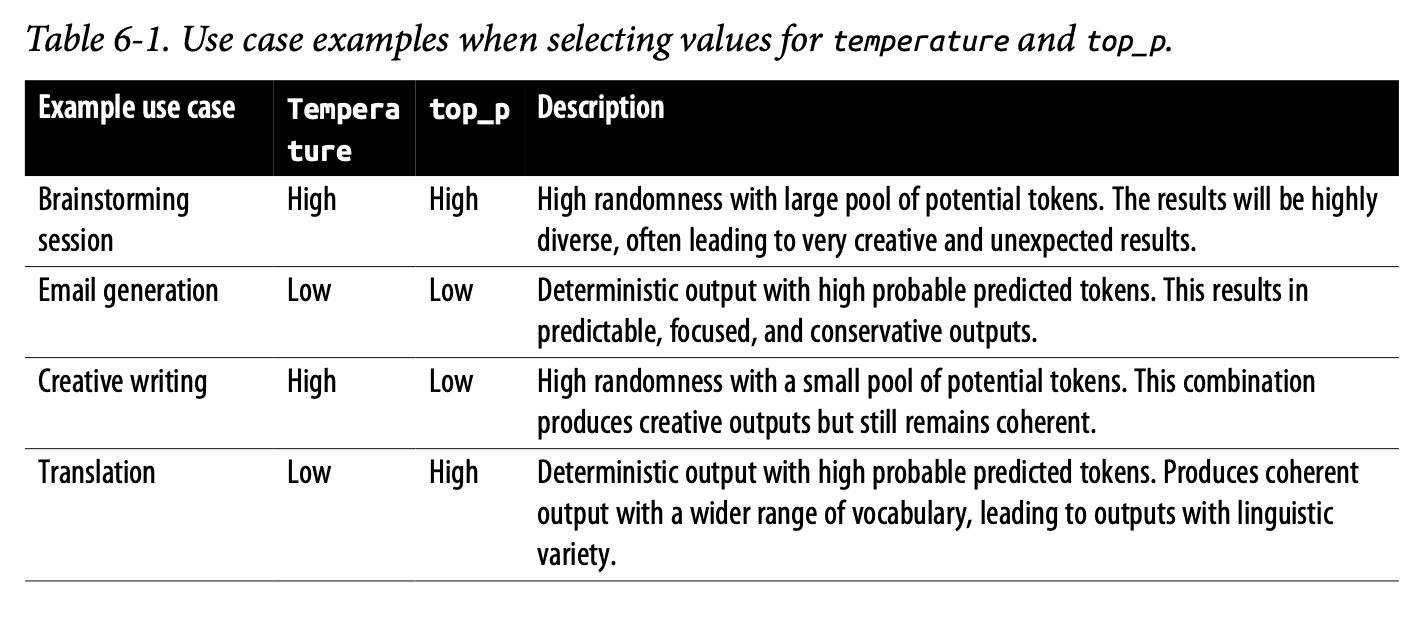

## Intro to Prompt Engineering

### Basic Ingredients of a Prompt

A basic example of a prompt. No instruction is given so the LLM will simply
try to complete the sentence.

We can add Two components to a basic instruction prompt: the instruction itself and the data it refers to.

We can also extend the prompt with an output indicator that allows for a specific output.


### Instruction Based Prompting

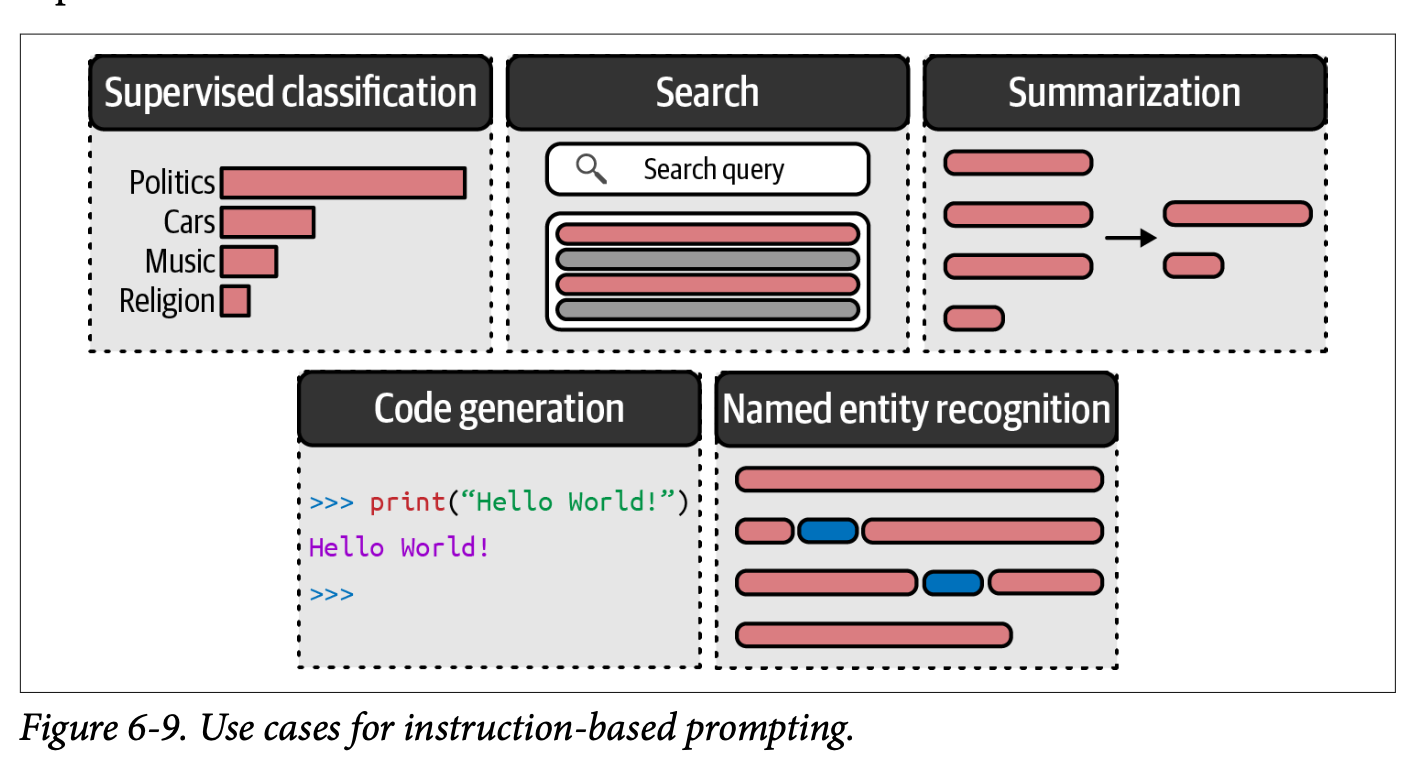

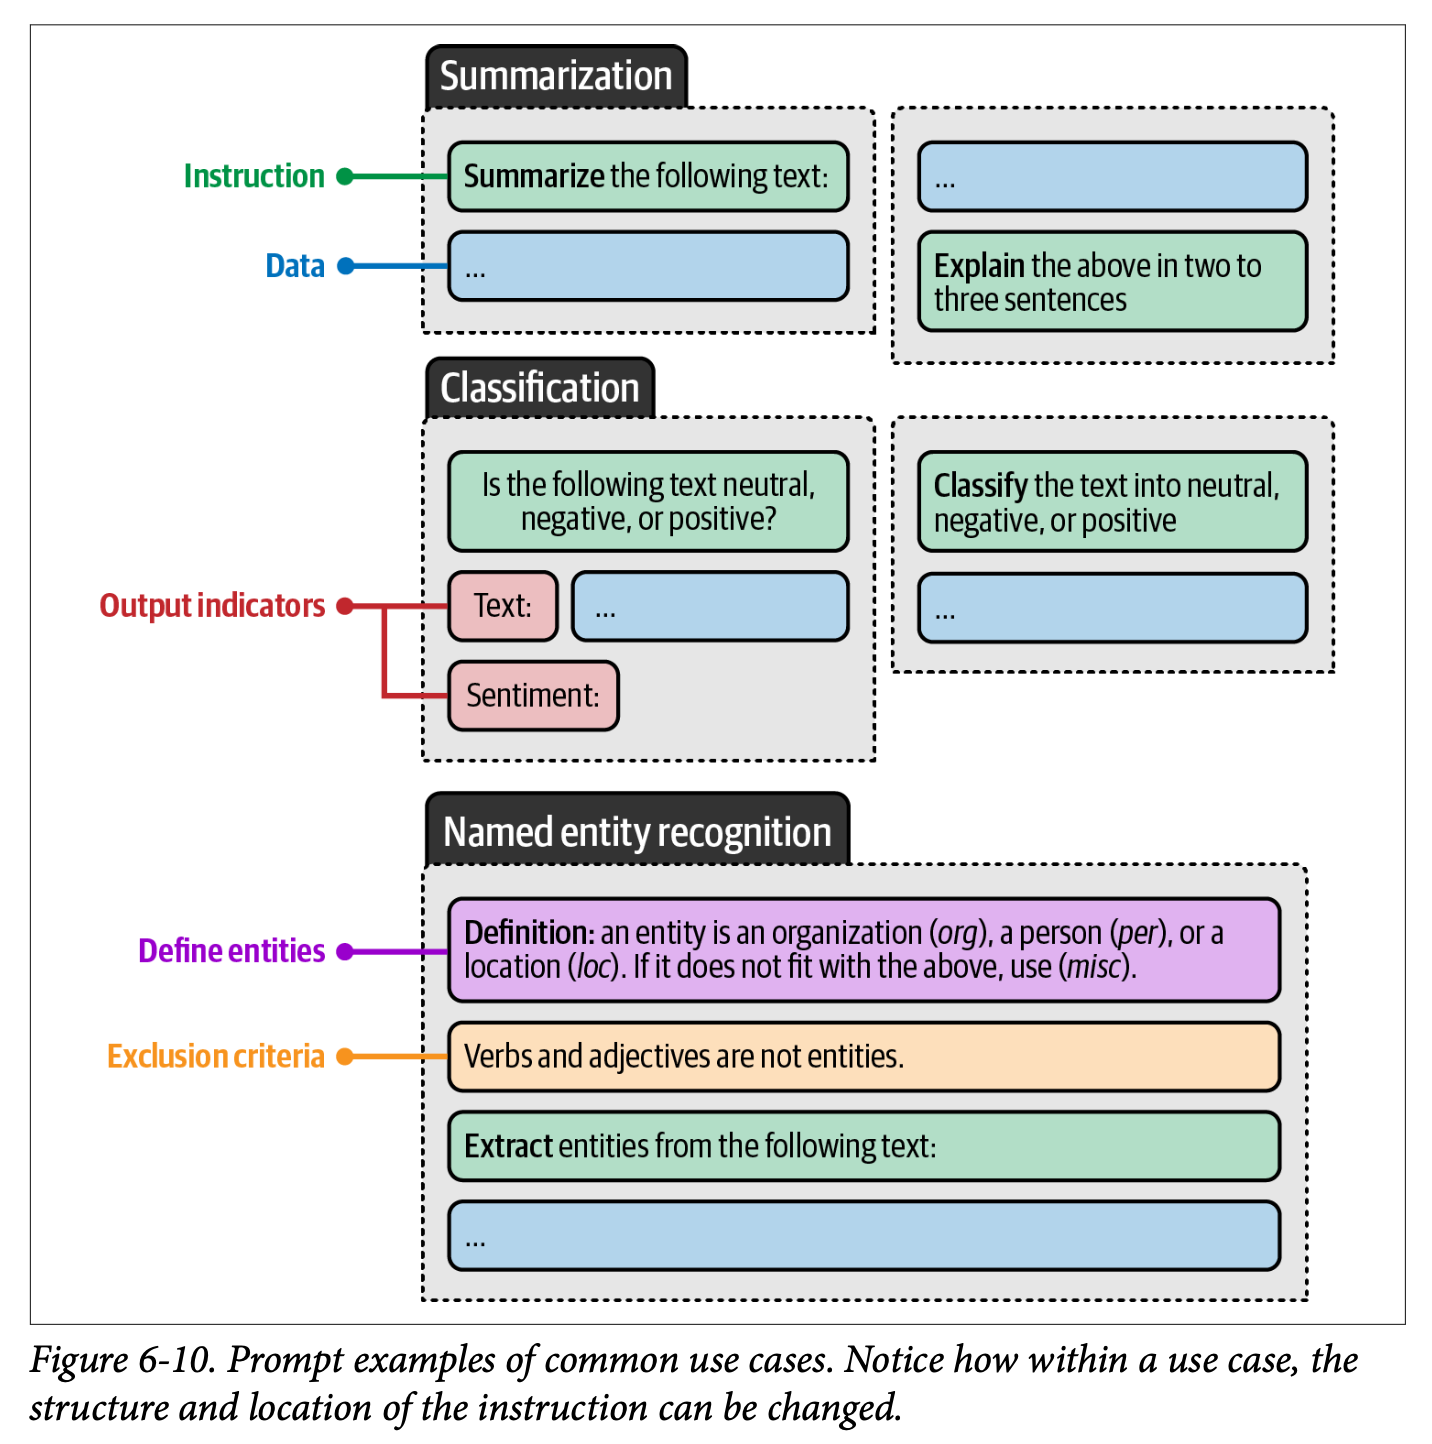

**Prompting Techniques**
- Specificity : Accurately describe what you want to achieve. Instead of asking the LLM to “Write a description for a product” ask it to “Write a description for a product inless than two sentences and use a formal tone.”

- Hallucination : LLMs may generate incorrect information confidently, which is referred to as hallucination. To reduce its impact, we can ask the LLM to only generate an answer if it knows the answer. If it does not know the answer, it can respond with “I don’t know.”

- Order : Either begin or end your prompt with the instruction. Especially with long prompts, information in the middle is often forgotten.1 LLMs tend to focus on information either at the beginning of a prompt (primacy effect) or the end of a prompt (recency effect).

## Advanced Prompt Engineering

### Potential Complexity of a Prompt
These advanced components can quickly make a prompt quite complex. Some common components are:

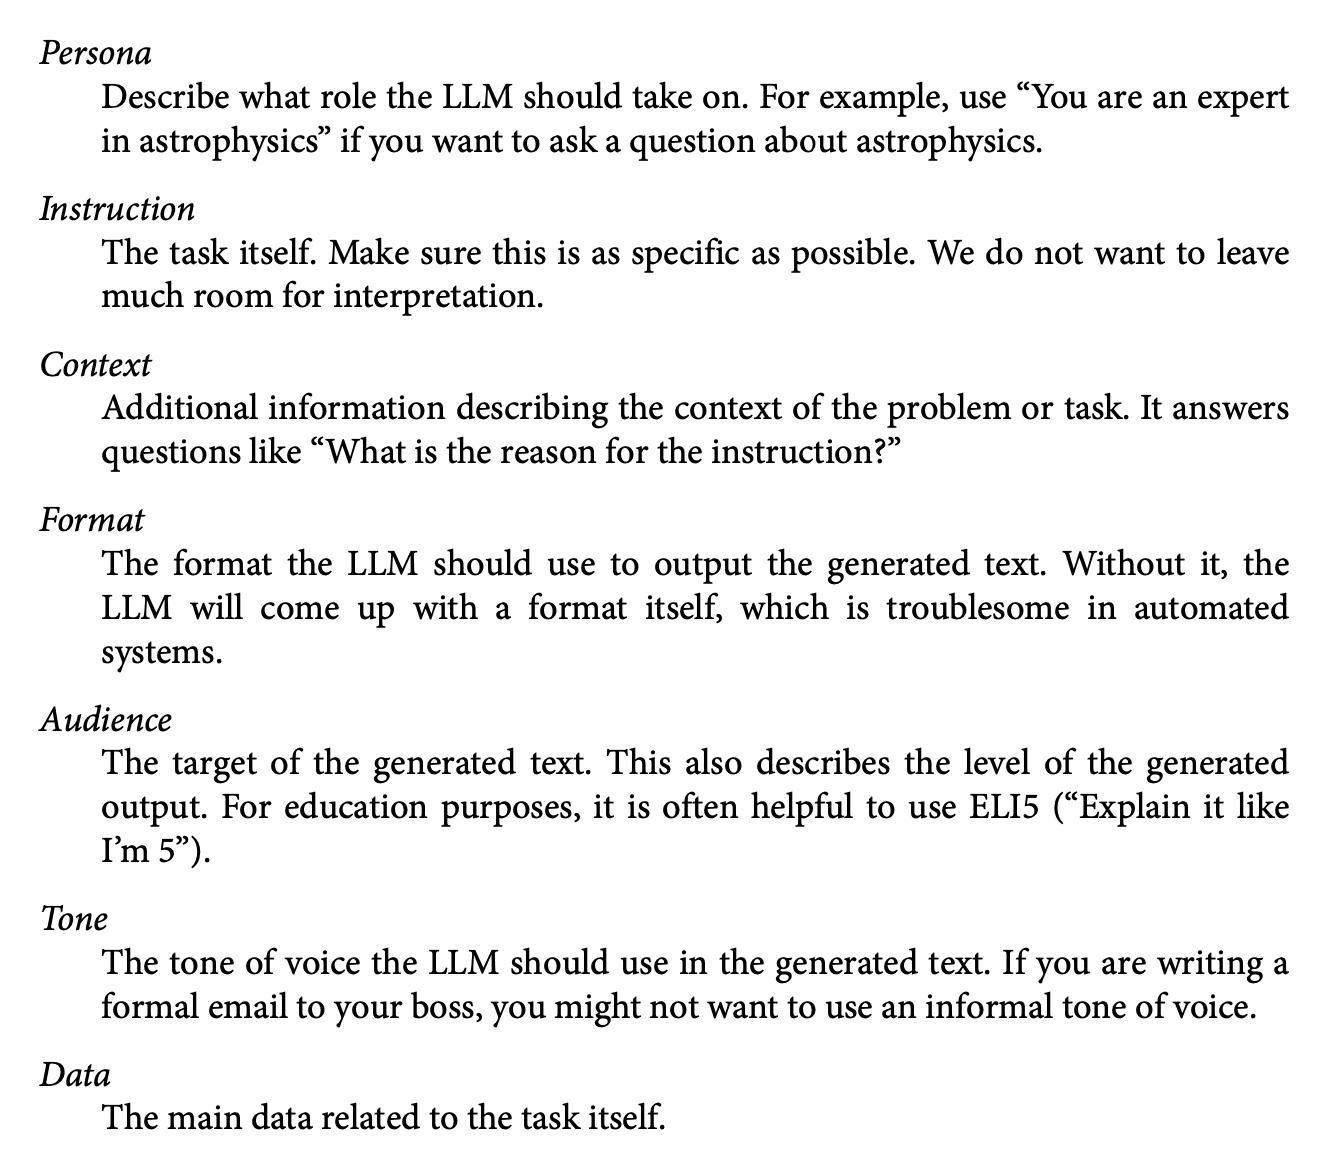

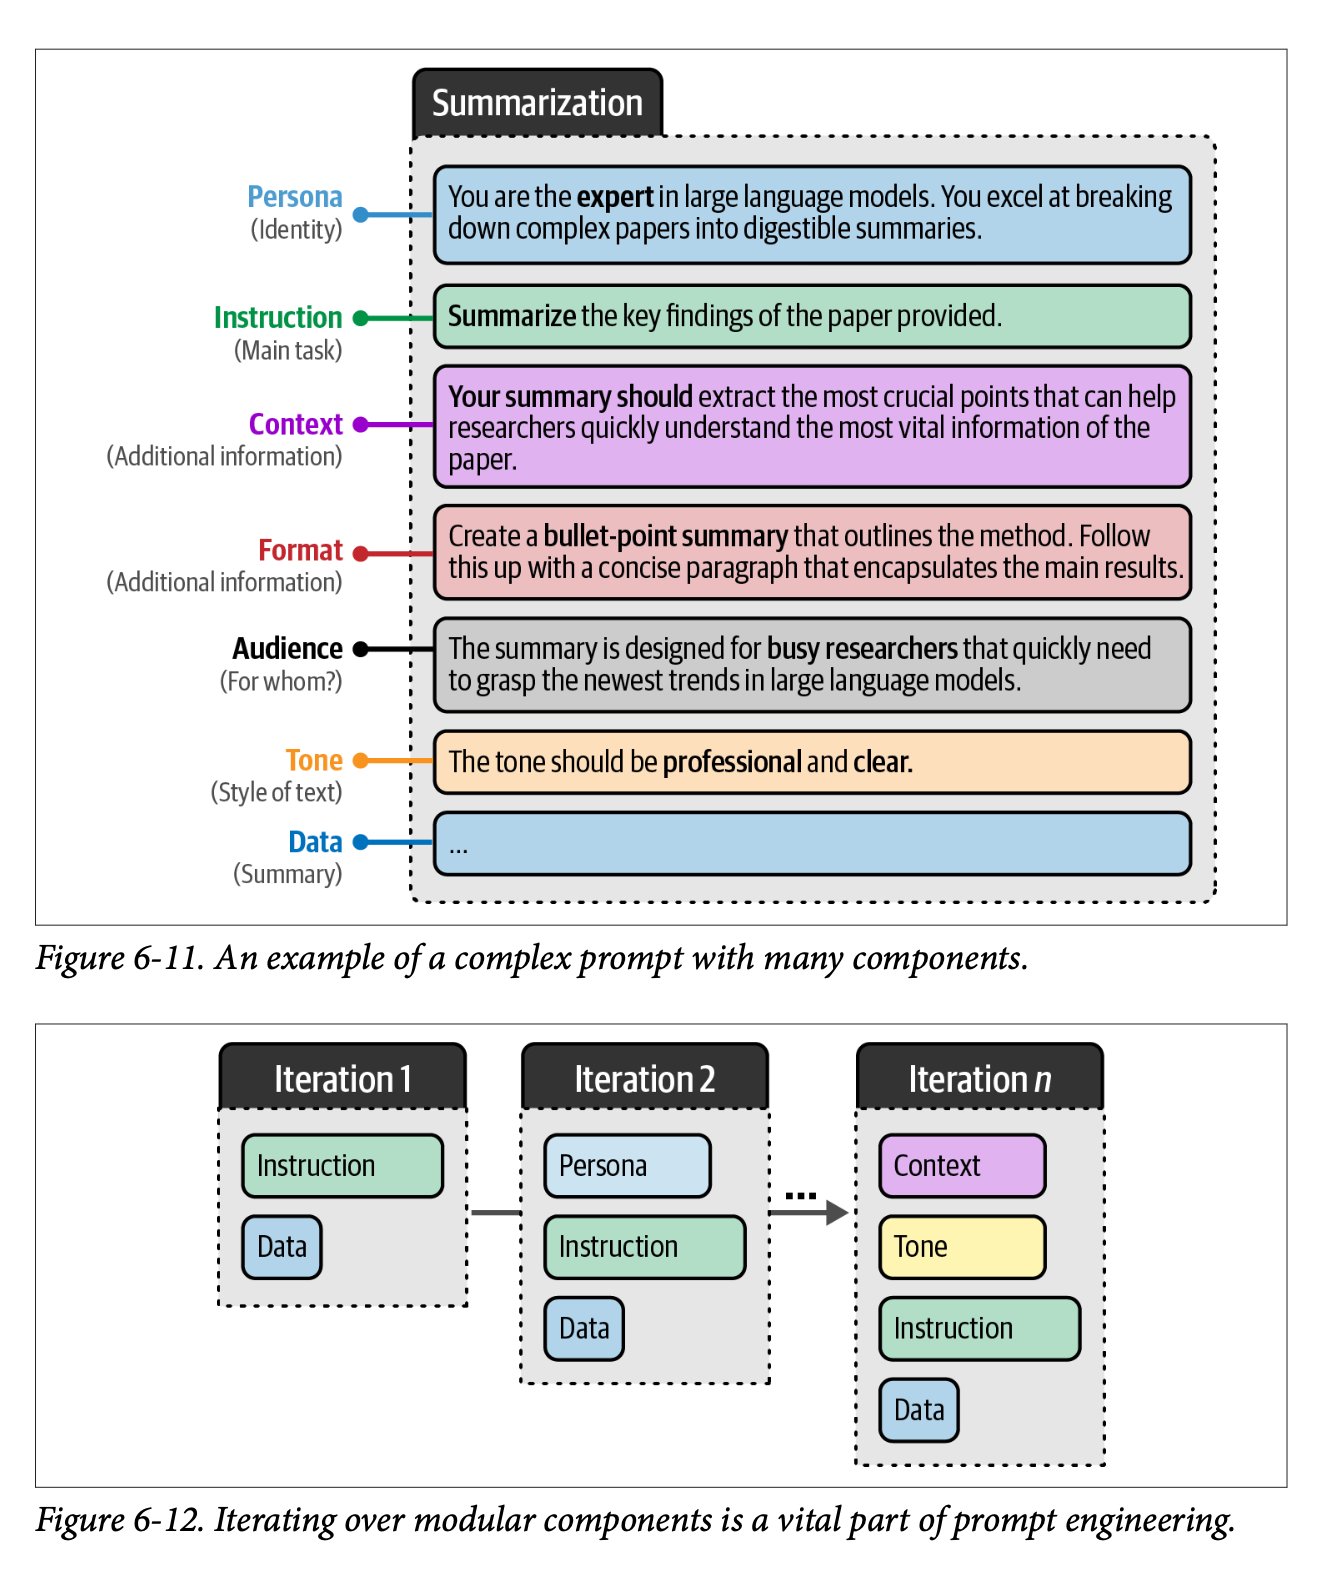



In [ ]:
# Prompt components
persona = "You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.\n"

instruction = "Summarize the key findings of the paper provided.\n"

context = "Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.\n"

data_format = "Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.\n"

audience = "The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.\n"

tone = "The tone should be professional and clear.\n"

text = ""

data = f"Text to summarize: {text}"


# The full prompt - remove and add pieces to view its impact on the generated output
query = persona + instruction + context + data_format + audience + tone + data

output = pipe(query, temperature = 0.2, top_p = 1)
print(output[0]["generated_text"])

### In-Context Learning : Providing Examples

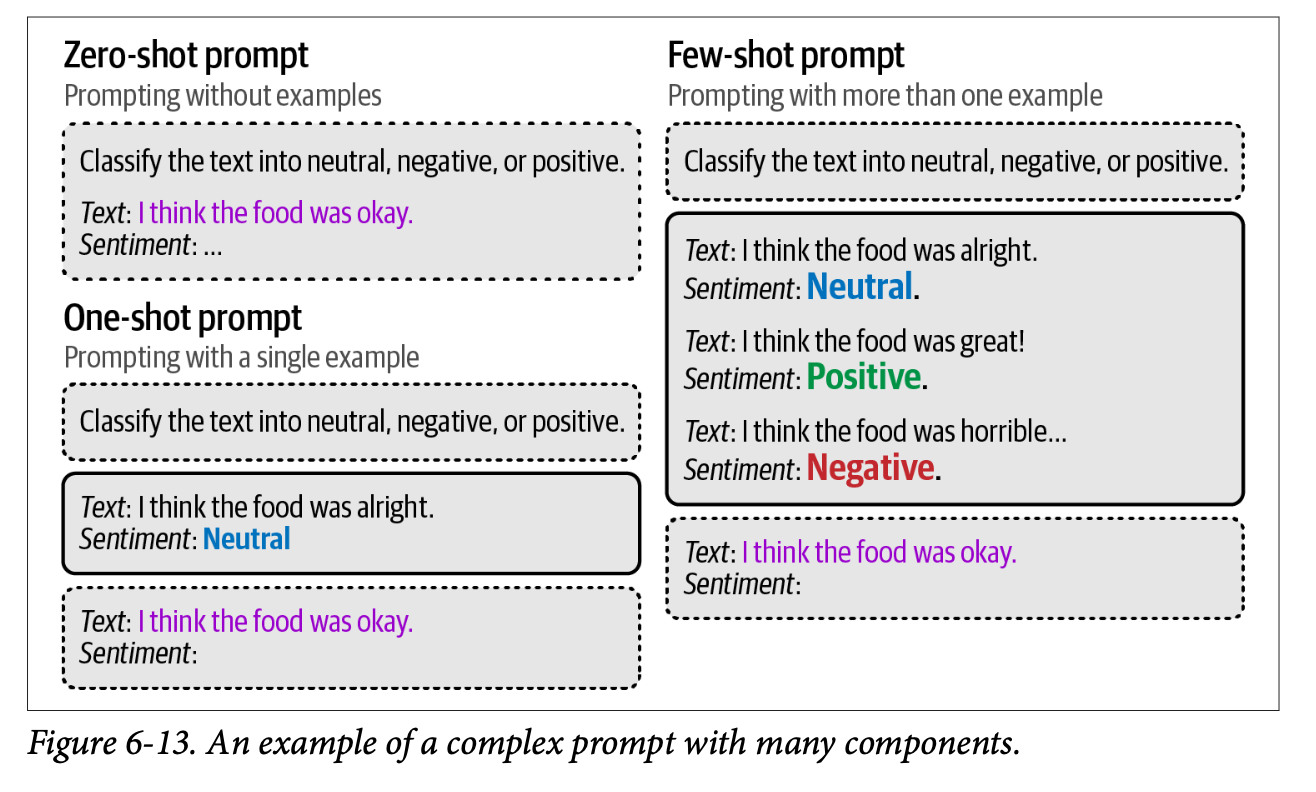



In [ ]:
# Use a single example of using the made-up word in a sentence
one_shot_prompt = [
{
"role": "user",
"content": "A 'Gigamuru' is a type of Japanese musical instrument. An example of a sentence that uses the word Gigamuru is:"
},
{
"role": "assistant",
"content": "I have a Gigamuru that my uncle gave me as a gift. I love to play it at home."
},
{
"role": "user",
"content": "To 'screeg' something is to swing a sword at it. An example of a sentence that uses the word screeg is:"
}
]

print(tokenizer.apply_chat_template(one_shot_prompt, tokenize = False))

In [ ]:
# Generate the output
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

### Chain Prompting : Breaking up the problem

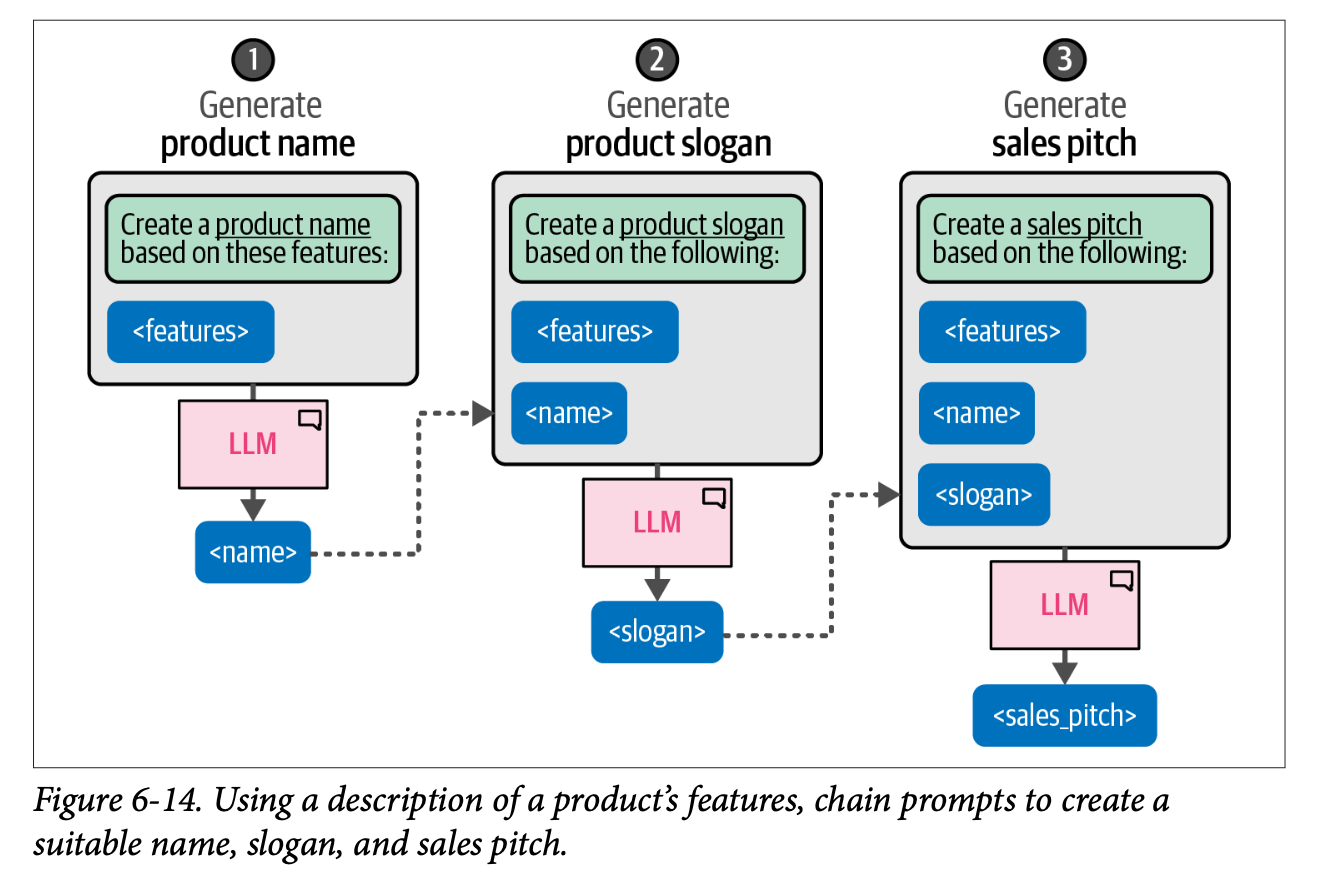

This can be used for a variety of use cases
- Response Validation : Ask the LLM to double check the previously generated outputs.
- Parallel Prompt : Create multiple prompts in parallel and do the final pass to merge them.
- Writing Stories : Leverage LLMs to write books or stories by breaking down the problem into components.

In [ ]:
# Create name and Slogan for a product
produce_prompt = [
    {
        "role" : "user",
        "content" : "Create a name and slogan for a chatbot that leverages LLMs"
    }
]

outputs = pipe(produce_prompt)
produce_description = outputs[0]["generated_text"]

print(produce_description)

In [ ]:
# Based on a name and slogan for a product generate a sales pitch
sales_prompt = [
    {
        "role" : "user",
        "content" : f"Generate a very short sales pitch for the following product : '{produce_description}'"
    }
]
outputs = pipe(sales_prompt)
sales_pitch = outputs[0]["generated_text"]
print(sales_pitch)

## Reasoning With Generative Model

Advanced prompt engineering techniques like prompt chaining, proved to be the first step towards enabling complex reasoning with generative models.

### Chain-of-Thought : Think before Answering

Chain-of-thought aims to have the generative model “think” first rather than answering the question directly without any reasoning.

Chain-of-thought prompting uses reasoning examples to persuade the gen‐
erative model to use reasoning in its answer.

In [ ]:
# Answering with chain-of-thought
cot_prompt = [
{"role": "user", "content": "Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?"},
{"role": "assistant", "content": "Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11."},
{"role": "user", "content": "The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?"}
]
# Generate the output
outputs = pipe(cot_prompt)
print(outputs[0]["generated_text"])

Instead of providing examples, we can simply ask the generative model to provide the reasoning (zero-shot chain-of-thought).

Chain-of-thought prompting without using examples. Instead, it uses the
phrase “Let’s think step-by-step” to prime reasoning in its answer.

In [ ]:
# Zero-Shot chain-of-thought
zeroshot_cot_prompt = [
    {
        "role": "user",
        "content" : "The cafeteria has 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have ? Let's think step-by-step"
    }
]

# Geneated the ouput
outputs = pipe(zeroshot_cot_prompt)
print(outputs[0]["generated_text"])

### Self-Consistency : Sampling Outputs

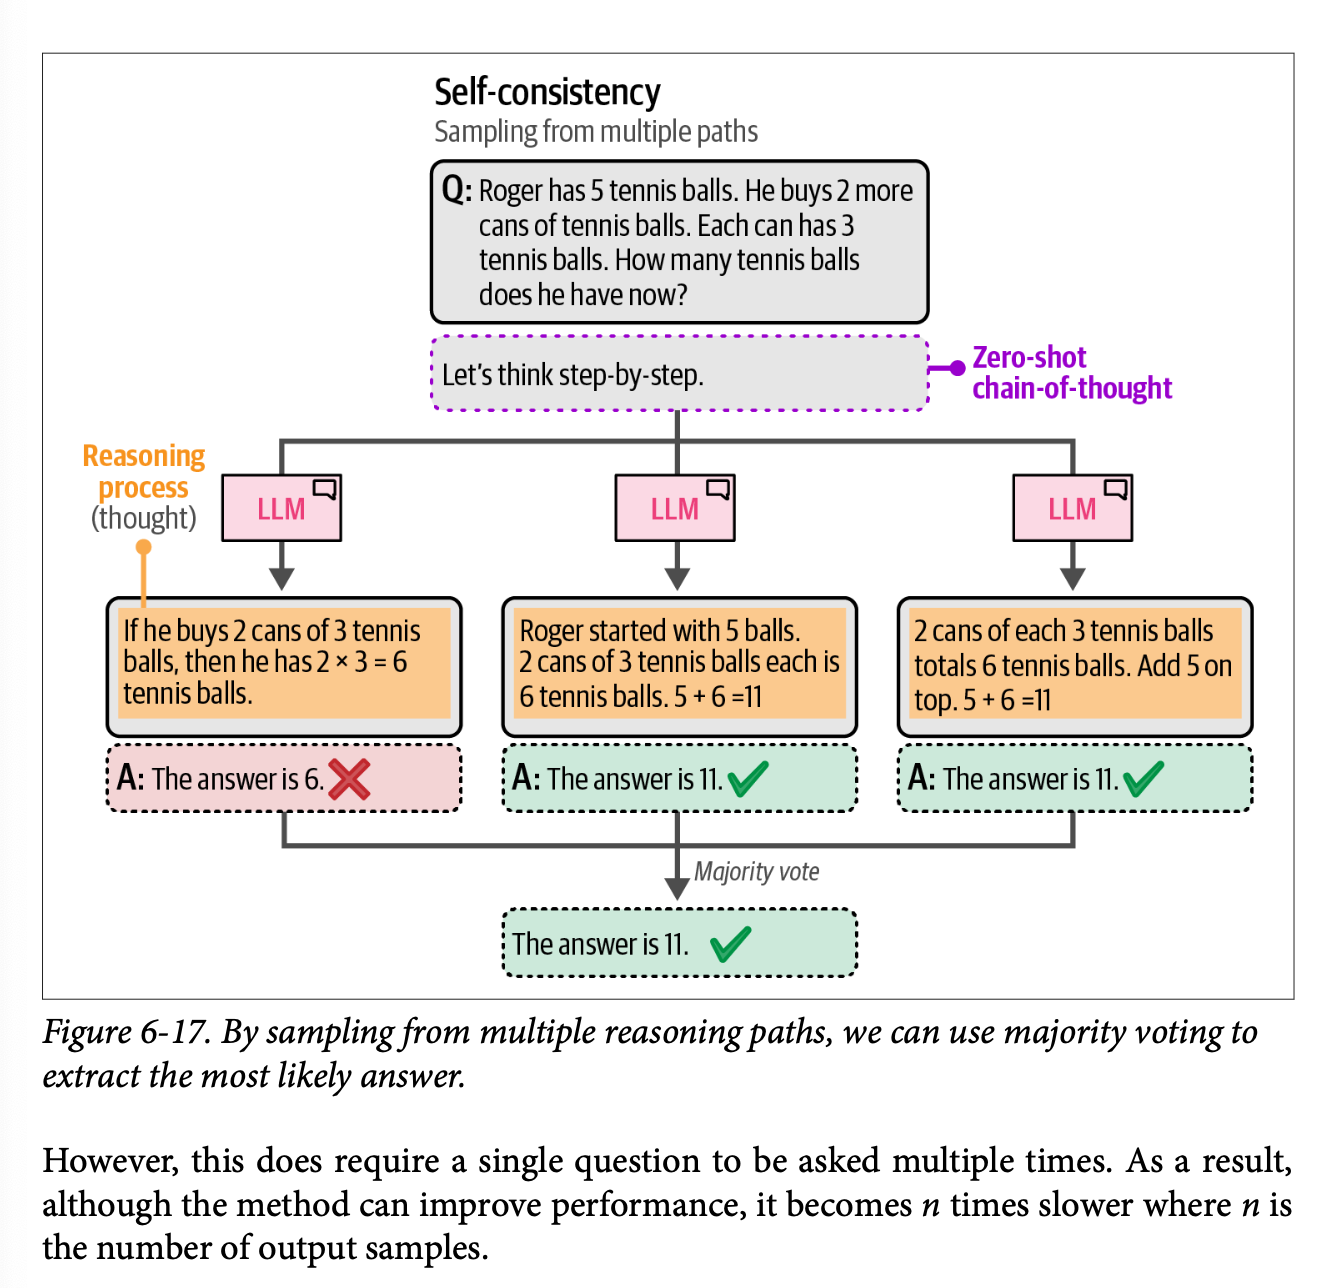



### Tree-of-Thought : Exploring the Intermediate Steps

The method works as follows. When faced with a problem that requires multiple reasoning steps, it often helps to break it down into pieces. At each step, and the generative model is prompted to explore different solutions to the problem at hand. It then votes for the best solution and continues to the next step.

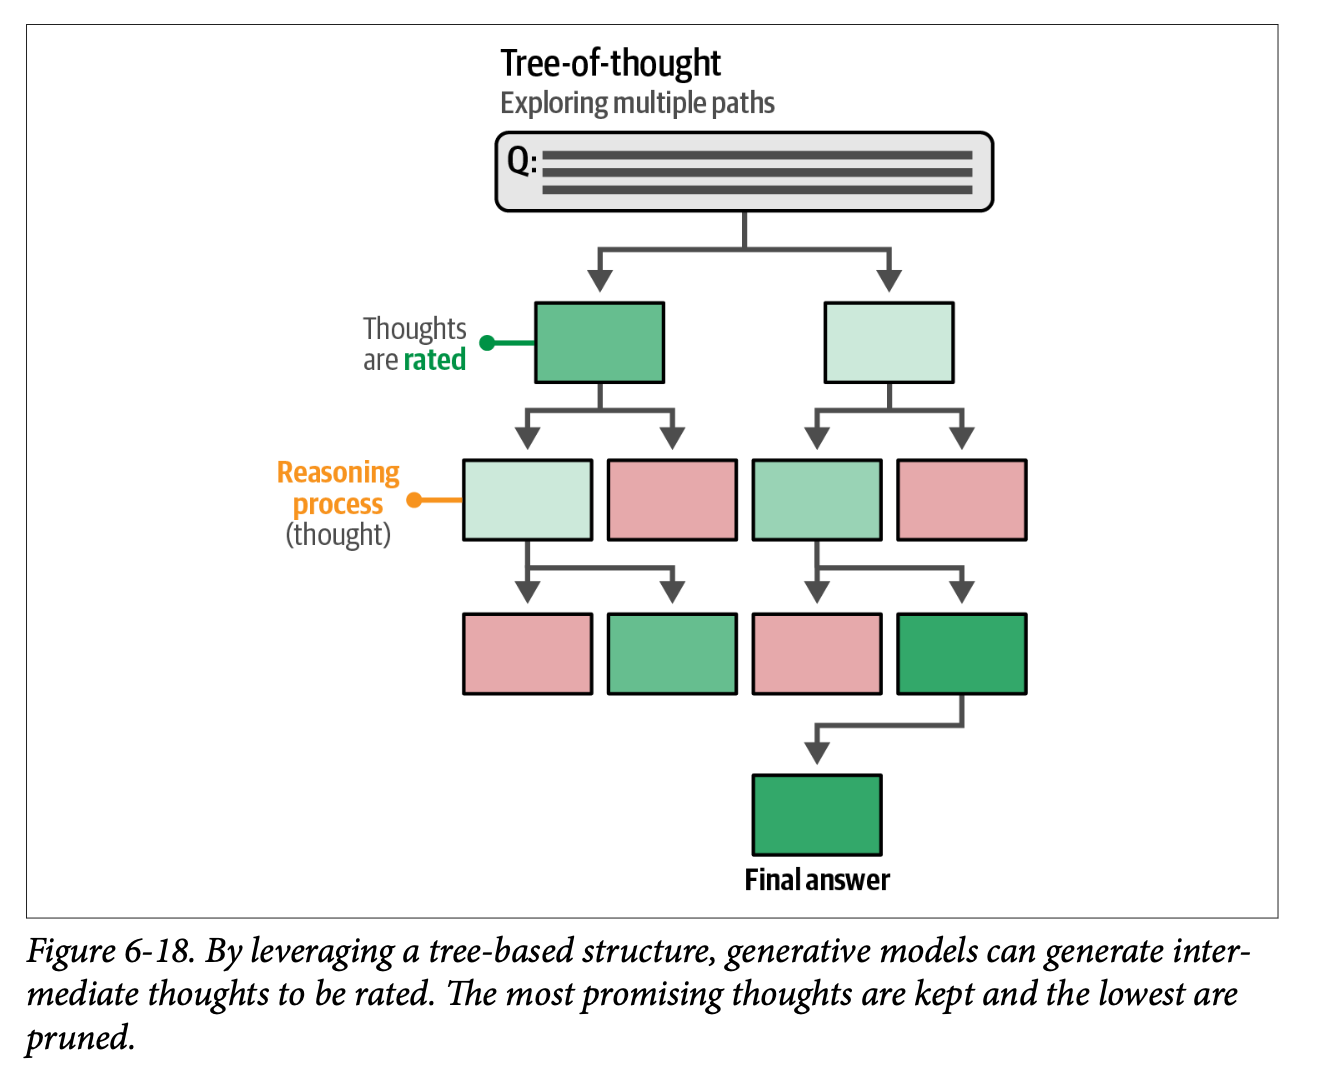

The model mimics the behavior by emulating a conversation between multiple experts. These experts will question each other until they reach a consensus.

In [ ]:
zeroshot_tot_prompt = [
    {
        "role" : "user",
        "content" : """Imagine three different experts are answering
this question. All experts will write down 1 step of their thinking, then share
it with the group. Then all experts will go on to the next step, etc. If any
expert realizes they're wrong at any point then they leave. The question is
'The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more,
how many apples do they have?' Make sure to discuss the results. """
    }
]

# Generate the output
outputs = pipe(zeroshot_tot_prompt)
print(outputs[0]['generated_text'])

## Output Verification 

### Providing Examples


In [ ]:
# One-shot learning: Providing an example of the output structure
one_shot_template = """Create a short character profile for an RPG game. Make
sure to only use this format:
{
"description": "A SHORT DESCRIPTION",
"name": "THE CHARACTER'S NAME",
"armor": "ONE PIECE OF ARMOR",
"weapon": "ONE OR MORE WEAPONS"
}
"""
one_shot_prompt = [
{"role": "user", "content": one_shot_template}
]
# Generate the output
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])

### Grammer Constrained Sampling

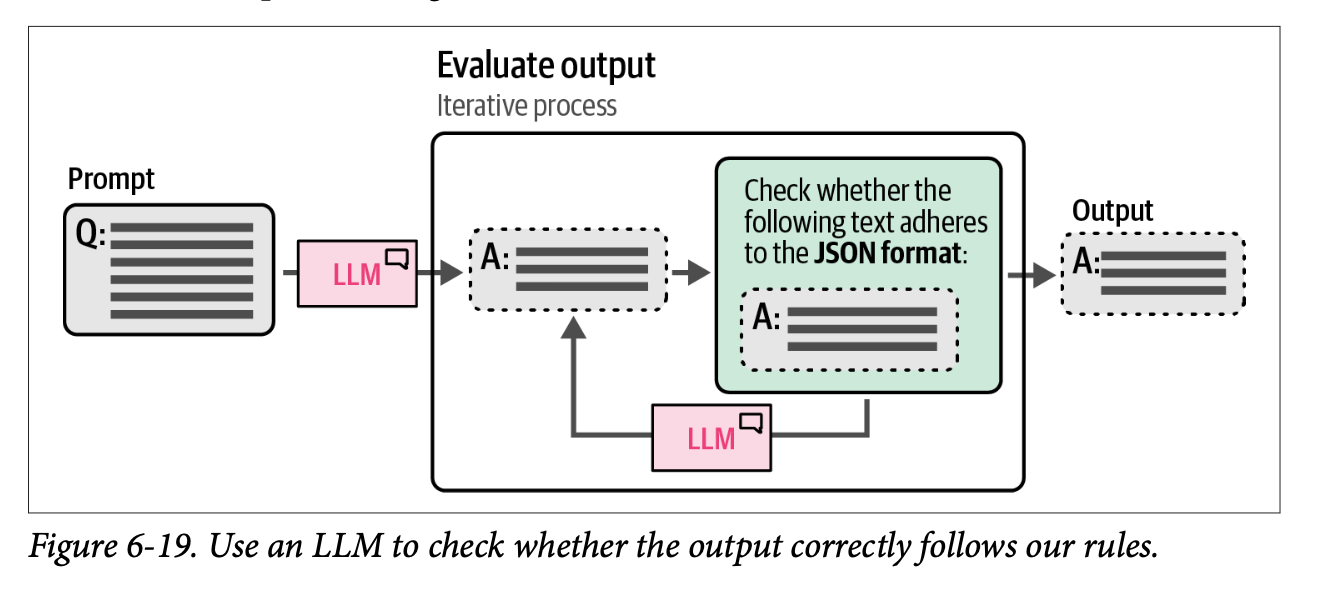

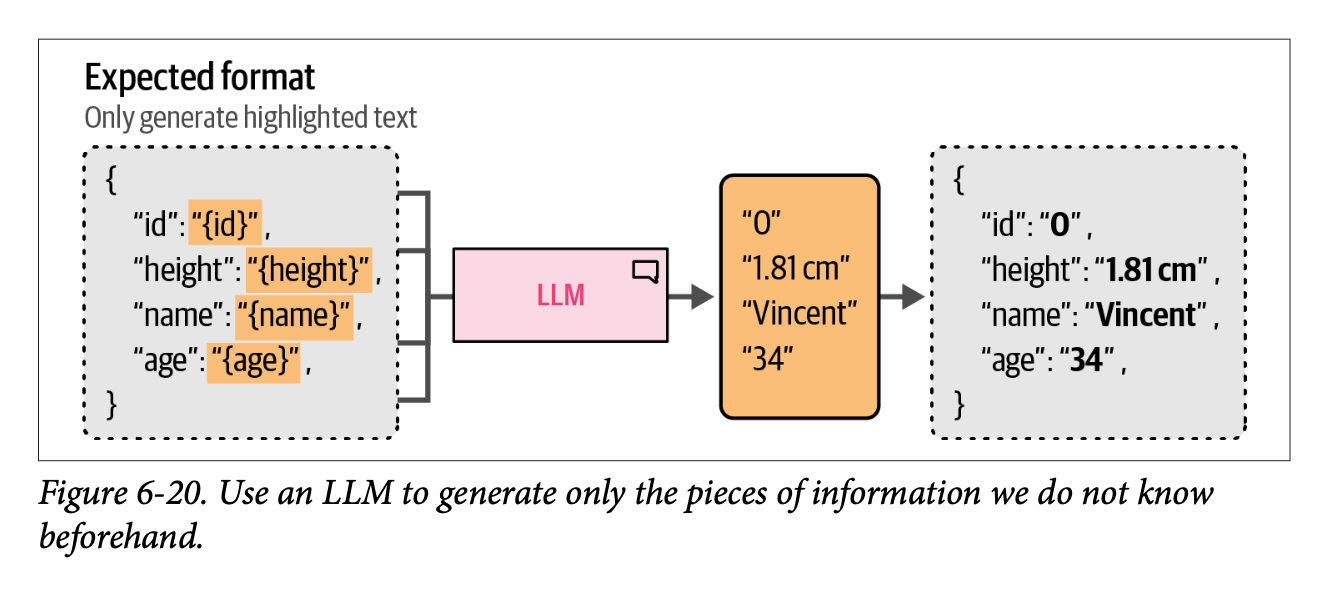

We load the same model we used throughout this chapter but use a different format instead, namely GGUF. llama-cpp-python expects this format, which is generally used for compressed (quantized) models.

In [ ]:
#  Clear all previous models and empty VRAM

import gc
import torch

del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.mps.empty_cache()

Now that we have cleared the memory, we can load Phi-3. We set n_gpu_layers to -1 to indicate that we want all layers of the model to be run from the GPU. The n_ctx refers to the context size of the model. The repo_id and filename refer to the Hugging Face repository where the model resides.

In [2]:
from llama_cpp.llama import Llama

# Load Phi-3
llm = Llama.from_pretrained(
    repo_id = "microsoft/Phi-3-mini-4k-instruct-gguf",
    filename = "*fp16.gguf",
    n_gpu_layers = -1,
    n_ctx = 2048,
    verbose = False
)

Phi-3-mini-4k-instruct-fp16.gguf:   0%|          | 0.00/7.64G [00:00<?, ?B/s]

llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [3]:
output = llm.create_chat_completion(
    messages = [
        {
            "role": "user",
            "content": "Create a warrior for an RPG in JSON for mat."
        }
    ],
    response_format = {"type": "json_object"},
    temperature = 0
)['choices'][0]['message']['content']

In [4]:
import json

# Format as json
json_output = json.dumps(json.loads(output), indent = 4)
print(json_output)

{
    "warrior": {
        "name": "Aldarion the Brave",
        "class": "Warrior",
        "level": 10,
        "attributes": {
            "strength": 18,
            "dexterity": 10,
            "constitution": 16,
            "intelligence": 8,
            "wisdom": 10,
            "charisma": 12
        },
        "skills": [
            {
                "name": "Martial Arts",
                "proficiency": 20,
                "description": "Aldarion is skilled in various martial arts, allowing him to fight with precision and power."
            },
            {
                "name": "Weapon Proficiency",
                "proficiency": 20,
                "description": "Aldarion is proficient in using a variety of weapons, including swords, axes, and maces."
            },
            {
                "name": "Survival",
                "proficiency": 15,
                "description": "Aldarion is adept at surviving in the wilderness, finding food, and building shelter."
